In [1]:
!pip install rouge-score nltk scikit-learn matplotlib seaborn

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c3151deef3b80a37249e72cf2a1734e4f6281d7062381d28f9ed3e49c02543d6
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [6]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

class ArabicCaptionEvaluator:
    """
    Comprehensive evaluation suite for Arabic image captioning with enhanced preprocessing
    """

    def __init__(self):
        self.rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)
        self.smoothing = SmoothingFunction().method1

        # Arabic diacritics (Tashkeel) for removal
        self.arabic_diacritics = re.compile(r'[\u064B-\u065F\u0670\u0640]')

        # Arabic punctuation marks
        self.arabic_punctuation = re.compile(r'[؟،؛٪٫٬‰؍]')

        # General punctuation
        self.general_punctuation = re.compile(r'[!"#$%&\'()*+,\-./:;<=>?@\[\]^_`{|}~]')

        # Multiple spaces
        self.multiple_spaces = re.compile(r'\s+')

        # Arabic letter normalization patterns
        self.alef_patterns = re.compile(r'[أإآا]')
        self.yeh_patterns = re.compile(r'[يى]')
        self.teh_patterns = re.compile(r'[ةه]')

    def normalize_arabic_text(self, text: str) -> str:
        """
        Advanced Arabic text normalization
        """
        if pd.isna(text) or text == '':
            return ''

        text = str(text).strip()

        # Remove Arabic diacritics (Tashkeel)
        text = self.arabic_diacritics.sub('', text)

        # Normalize Arabic letters
        text = self.alef_patterns.sub('ا', text)  # Normalize all Alef variants to basic Alef
        text = self.yeh_patterns.sub('ي', text)   # Normalize Yeh variants
        text = self.teh_patterns.sub('ة', text)   # Normalize Teh Marbuta

        # Remove punctuation (both Arabic and general)
        text = self.arabic_punctuation.sub(' ', text)
        text = self.general_punctuation.sub(' ', text)

        # Remove numbers and English characters
        text = re.sub(r'[0-9a-zA-Z]', ' ', text)

        # Remove extra whitespace
        text = self.multiple_spaces.sub(' ', text)

        # Remove leading/trailing whitespace
        text = text.strip()

        return text

    def advanced_tokenize_arabic(self, text: str) -> List[str]:
        """
        Advanced Arabic tokenization with normalization
        """
        normalized_text = self.normalize_arabic_text(text)

        if not normalized_text:
            return []

        # Split by whitespace
        tokens = normalized_text.split()

        # Filter out very short tokens (less than 2 characters)
        tokens = [token for token in tokens if len(token) >= 2]

        return tokens

    def clean_for_rouge(self, text: str) -> str:
        """
        Clean text specifically for ROUGE evaluation
        """
        if pd.isna(text) or text == '':
            return ''

        text = str(text).strip()

        # Remove diacritics
        text = self.arabic_diacritics.sub('', text)

        # Normalize Arabic letters
        text = self.alef_patterns.sub('ا', text)
        text = self.yeh_patterns.sub('ي', text)
        text = self.teh_patterns.sub('ة', text)

        # Keep some punctuation for ROUGE but clean excessive ones
        text = re.sub(r'[0-9a-zA-Z]', ' ', text)
        text = self.multiple_spaces.sub(' ', text)

        return text.strip()

    def calculate_bleu_score(self, reference: str, candidate: str) -> Dict[str, float]:
        """
        Calculate BLEU scores with advanced tokenization
        """
        ref_tokens = self.advanced_tokenize_arabic(reference)
        cand_tokens = self.advanced_tokenize_arabic(candidate)

        if not ref_tokens or not cand_tokens:
            return {'bleu1': 0.0, 'bleu2': 0.0, 'bleu3': 0.0, 'bleu4': 0.0}

        # BLEU expects list of references
        reference_list = [ref_tokens]

        try:
            bleu1 = sentence_bleu(reference_list, cand_tokens, weights=(1, 0, 0, 0), smoothing_function=self.smoothing)
            bleu2 = sentence_bleu(reference_list, cand_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=self.smoothing)
            bleu3 = sentence_bleu(reference_list, cand_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=self.smoothing)
            bleu4 = sentence_bleu(reference_list, cand_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=self.smoothing)
        except:
            return {'bleu1': 0.0, 'bleu2': 0.0, 'bleu3': 0.0, 'bleu4': 0.0}

        return {
            'bleu1': round(bleu1, 4),
            'bleu2': round(bleu2, 4),
            'bleu3': round(bleu3, 4),
            'bleu4': round(bleu4, 4)
        }

    def calculate_rouge_scores(self, reference: str, candidate: str) -> Dict[str, float]:
        """
        Calculate ROUGE scores with Arabic-specific cleaning
        """
        ref_clean = self.clean_for_rouge(reference)
        cand_clean = self.clean_for_rouge(candidate)

        if not ref_clean or not cand_clean:
            return {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}

        try:
            scores = self.rouge_scorer.score(ref_clean, cand_clean)
            return {
                'rouge1': round(scores['rouge1'].fmeasure, 4),
                'rouge2': round(scores['rouge2'].fmeasure, 4),
                'rougeL': round(scores['rougeL'].fmeasure, 4)
            }
        except:
            return {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}

    def calculate_cosine_similarity(self, reference: str, candidate: str) -> float:
        """
        Calculate cosine similarity with normalized text
        """
        ref_clean = self.normalize_arabic_text(reference)
        cand_clean = self.normalize_arabic_text(candidate)

        if not ref_clean or not cand_clean:
            return 0.0

        try:
            # Use character n-grams (1-4) for better Arabic similarity
            vectorizer = TfidfVectorizer(
                analyzer='char',
                ngram_range=(1, 4),
                lowercase=False,
                strip_accents=None
            )
            vectors = vectorizer.fit_transform([ref_clean, cand_clean])
            similarity = cosine_similarity(vectors[0:1], vectors[1:2])[0][0]
            return round(similarity, 4)
        except:
            return 0.0

    def calculate_word_similarity(self, reference: str, candidate: str) -> float:
        """
        Calculate word-level cosine similarity
        """
        ref_tokens = self.advanced_tokenize_arabic(reference)
        cand_tokens = self.advanced_tokenize_arabic(candidate)

        if not ref_tokens or not cand_tokens:
            return 0.0

        try:
            # Join tokens back for TF-IDF
            ref_text = ' '.join(ref_tokens)
            cand_text = ' '.join(cand_tokens)

            vectorizer = TfidfVectorizer(
                analyzer='word',
                lowercase=False,
                strip_accents=None
            )
            vectors = vectorizer.fit_transform([ref_text, cand_text])
            similarity = cosine_similarity(vectors[0:1], vectors[1:2])[0][0]
            return round(similarity, 4)
        except:
            return 0.0

    def calculate_jaccard_similarity(self, reference: str, candidate: str) -> float:
        """
        Calculate Jaccard similarity coefficient
        """
        ref_tokens = set(self.advanced_tokenize_arabic(reference))
        cand_tokens = set(self.advanced_tokenize_arabic(candidate))

        if not ref_tokens or not cand_tokens:
            return 0.0

        intersection = len(ref_tokens.intersection(cand_tokens))
        union = len(ref_tokens.union(cand_tokens))

        if union == 0:
            return 0.0

        jaccard_sim = intersection / union
        return round(jaccard_sim, 4)

    def calculate_lin_similarity(self, reference: str, candidate: str) -> float:
        """
        Calculate Lin similarity (Dice coefficient) with advanced tokenization
        """
        ref_tokens = set(self.advanced_tokenize_arabic(reference))
        cand_tokens = set(self.advanced_tokenize_arabic(candidate))

        if not ref_tokens or not cand_tokens:
            return 0.0

        intersection = len(ref_tokens.intersection(cand_tokens))
        total = len(ref_tokens) + len(cand_tokens)

        if total == 0:
            return 0.0

        lin_sim = (2.0 * intersection) / total
        return round(lin_sim, 4)

    def calculate_semantic_similarity(self, reference: str, candidate: str) -> float:
        """
        Enhanced semantic similarity using weighted word overlap
        """
        ref_tokens = self.advanced_tokenize_arabic(reference)
        cand_tokens = self.advanced_tokenize_arabic(candidate)

        if not ref_tokens or not cand_tokens:
            return 0.0

        # Count word frequencies
        ref_counter = Counter(ref_tokens)
        cand_counter = Counter(cand_tokens)

        # Calculate weighted overlap
        common_words = set(ref_tokens).intersection(set(cand_tokens))

        if not common_words:
            return 0.0

        # Calculate precision and recall with frequency weighting
        overlap_score = 0
        total_ref_freq = sum(ref_counter.values())
        total_cand_freq = sum(cand_counter.values())

        for word in common_words:
            # Weight by frequency
            ref_weight = ref_counter[word] / total_ref_freq
            cand_weight = cand_counter[word] / total_cand_freq
            overlap_score += min(ref_weight, cand_weight)

        # Normalize by average document length
        avg_length = (len(ref_tokens) + len(cand_tokens)) / 2
        normalized_score = overlap_score * avg_length

        return round(min(normalized_score, 1.0), 4)

    def evaluate_single_pair(self, reference: str, candidate: str) -> Dict[str, float]:
        """
        Evaluate a single reference-candidate pair with all metrics
        """
        # BLEU scores
        bleu_scores = self.calculate_bleu_score(reference, candidate)

        # ROUGE scores
        rouge_scores = self.calculate_rouge_scores(reference, candidate)

        # Similarity metrics
        char_cosine_sim = self.calculate_cosine_similarity(reference, candidate)
        word_cosine_sim = self.calculate_word_similarity(reference, candidate)
        jaccard_sim = self.calculate_jaccard_similarity(reference, candidate)
        lin_sim = self.calculate_lin_similarity(reference, candidate)
        semantic_sim = self.calculate_semantic_similarity(reference, candidate)

        # Combine all metrics
        results = {
            **bleu_scores,
            **rouge_scores,
            'char_cosine_similarity': char_cosine_sim,
            'word_cosine_similarity': word_cosine_sim,
            'jaccard_similarity': jaccard_sim,
            'lin_similarity': lin_sim,
            'semantic_similarity': semantic_sim
        }

        return results

    def evaluate_dataset(self, df: pd.DataFrame, ref_col: str = 'Description',
                        cand_col: str = 'arabic_caption') -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Evaluate entire dataset and return both metrics and detailed results
        """
        print(f"Evaluating {len(df)} caption pairs with enhanced preprocessing...")

        results = []

        # Reset index to ensure sequential numbering
        df_reset = df.reset_index(drop=True)

        for idx, row in df_reset.iterrows():
            reference = row[ref_col]
            candidate = row[cand_col]

            scores = self.evaluate_single_pair(reference, candidate)
            scores['original_index'] = idx
            results.append(scores)

            if (idx + 1) % 50 == 0:
                print(f"Processed {idx + 1}/{len(df)} pairs...")

        # Create metrics DataFrame
        results_df = pd.DataFrame(results)

        # Create detailed results DataFrame by merging original data with metrics
        detailed_results_df = df_reset.copy()

        # Add all evaluation metrics to the detailed DataFrame
        for metric in results_df.columns:
            if metric != 'original_index':
                detailed_results_df[metric] = results_df[metric].values

        # Add some additional computed columns for analysis
        detailed_results_df['reference_length'] = detailed_results_df[ref_col].apply(
            lambda x: len(self.advanced_tokenize_arabic(x)) if pd.notna(x) else 0
        )
        detailed_results_df['candidate_length'] = detailed_results_df[cand_col].apply(
            lambda x: len(self.advanced_tokenize_arabic(x)) if pd.notna(x) else 0
        )
        detailed_results_df['length_ratio'] = detailed_results_df.apply(
            lambda row: row['candidate_length'] / row['reference_length']
            if row['reference_length'] > 0 else 0, axis=1
        )

        # Add normalized texts for inspection
        detailed_results_df['reference_normalized'] = detailed_results_df[ref_col].apply(
            self.normalize_arabic_text
        )
        detailed_results_df['candidate_normalized'] = detailed_results_df[cand_col].apply(
            self.normalize_arabic_text
        )

        return results_df, detailed_results_df

    def generate_summary_report(self, results_df: pd.DataFrame) -> Dict[str, float]:
        """
        Generate comprehensive summary statistics
        """
        metrics = ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'rouge1', 'rouge2', 'rougeL',
                  'char_cosine_similarity', 'word_cosine_similarity', 'jaccard_similarity',
                  'lin_similarity', 'semantic_similarity']

        summary = {}
        for metric in metrics:
            summary[f'{metric}_mean'] = round(results_df[metric].mean(), 4)
            summary[f'{metric}_std'] = round(results_df[metric].std(), 4)
            summary[f'{metric}_median'] = round(results_df[metric].median(), 4)
            summary[f'{metric}_min'] = round(results_df[metric].min(), 4)
            summary[f'{metric}_max'] = round(results_df[metric].max(), 4)

        return summary

    def plot_evaluation_results(self, results_df: pd.DataFrame, save_path: str = None):
        """
        Create comprehensive visualization of evaluation results
        """
        metrics = ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'rouge1', 'rouge2', 'rougeL',
                  'char_cosine_similarity', 'word_cosine_similarity', 'jaccard_similarity',
                  'lin_similarity', 'semantic_similarity']

        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        axes = axes.flatten()

        # 1. Box plot of all metrics
        ax1 = axes[0]
        results_df[metrics].boxplot(ax=ax1)
        ax1.set_title('Distribution of All Evaluation Metrics', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Score')
        ax1.tick_params(axis='x', rotation=45)

        # 2. BLEU scores comparison
        ax2 = axes[1]
        bleu_metrics = ['bleu1', 'bleu2', 'bleu3', 'bleu4']
        bleu_means = [results_df[metric].mean() for metric in bleu_metrics]
        bars = ax2.bar(bleu_metrics, bleu_means, color=['lightblue', 'skyblue', 'deepskyblue', 'steelblue'])
        ax2.set_title('BLEU Scores Comparison', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Average Score')
        for bar, value in zip(bars, bleu_means):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=9)

        # 3. ROUGE scores comparison
        ax3 = axes[2]
        rouge_metrics = ['rouge1', 'rouge2', 'rougeL']
        rouge_means = [results_df[metric].mean() for metric in rouge_metrics]
        bars = ax3.bar(rouge_metrics, rouge_means, color=['lightcoral', 'coral', 'tomato'])
        ax3.set_title('ROUGE Scores Comparison', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Average Score')
        for bar, value in zip(bars, rouge_means):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=9)

        # 4. Similarity metrics comparison
        ax4 = axes[3]
        sim_metrics = ['char_cosine_similarity', 'word_cosine_similarity', 'jaccard_similarity',
                      'lin_similarity', 'semantic_similarity']
        sim_means = [results_df[metric].mean() for metric in sim_metrics]
        sim_labels = ['Char Cosine', 'Word Cosine', 'Jaccard', 'Lin', 'Semantic']
        bars = ax4.bar(sim_labels, sim_means, color=['lightgreen', 'green', 'forestgreen', 'darkgreen', 'olive'])
        ax4.set_title('Similarity Metrics Comparison', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Average Score')
        ax4.tick_params(axis='x', rotation=45)
        for bar, value in zip(bars, sim_means):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=8)

        # 5. Correlation heatmap
        ax5 = axes[4]
        correlation_matrix = results_df[metrics].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=ax5,
                   square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
        ax5.set_title('Metric Correlation Matrix', fontsize=12, fontweight='bold')

        # 6. Distribution of best performing metric
        ax6 = axes[5]
        best_metric = 'bleu4'  # or choose based on highest mean
        ax6.hist(results_df[best_metric], bins=25, alpha=0.7, color='gold', edgecolor='black')
        ax6.set_title(f'Distribution of {best_metric.upper()} Scores', fontsize=12, fontweight='bold')
        ax6.set_xlabel(f'{best_metric.upper()} Score')
        ax6.set_ylabel('Frequency')
        ax6.axvline(results_df[best_metric].mean(), color='red', linestyle='--',
                   label=f'Mean: {results_df[best_metric].mean():.3f}')
        ax6.legend()

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

# Main evaluation function
def evaluate_arabic_captions(df: pd.DataFrame, ref_col: str = 'Description',
                           cand_col: str = 'arabic_caption', save_results: bool = True):
    """
    Main function to evaluate Arabic captions with enhanced preprocessing

    Args:
        df: DataFrame with reference and candidate columns
        ref_col: Name of reference (ground truth) column
        cand_col: Name of candidate (generated) column
        save_results: Whether to save results to files

    Returns:
        Dictionary with results dataframe, detailed results, and summary
    """

    print("🚀 Starting Enhanced Arabic Caption Evaluation...")
    print(f"Dataset size: {len(df)} samples")
    print(f"Reference column: {ref_col}")
    print(f"Candidate column: {cand_col}")

    # Initialize evaluator
    evaluator = ArabicCaptionEvaluator()

    # Run evaluation - now returns both metrics and detailed results
    results_df, detailed_results_df = evaluator.evaluate_dataset(df, ref_col, cand_col)

    # Generate summary
    summary = evaluator.generate_summary_report(results_df)

    # Print comprehensive summary
    print("\n📊 ENHANCED EVALUATION SUMMARY")
    print("=" * 60)

    metrics_display = {
        'BLEU-1': 'bleu1_mean',
        'BLEU-2': 'bleu2_mean',
        'BLEU-3': 'bleu3_mean',
        'BLEU-4': 'bleu4_mean',
        'ROUGE-1': 'rouge1_mean',
        'ROUGE-2': 'rouge2_mean',
        'ROUGE-L': 'rougeL_mean',
        'Char Cosine Sim': 'char_cosine_similarity_mean',
        'Word Cosine Sim': 'word_cosine_similarity_mean',
        'Jaccard Sim': 'jaccard_similarity_mean',
        'Lin Similarity': 'lin_similarity_mean',
        'Semantic Sim': 'semantic_similarity_mean'
    }

    for display_name, metric_key in metrics_display.items():
        mean_val = summary[metric_key]
        std_val = summary[metric_key.replace('_mean', '_std')]
        max_val = summary[metric_key.replace('_mean', '_max')]
        print(f"{display_name:18}: {mean_val:.4f} (±{std_val:.4f}) [Max: {max_val:.4f}]")

    # Print additional statistics
    print(f"\nDataset Statistics:")
    print(f"Average reference length: {detailed_results_df['reference_length'].mean():.2f} words")
    print(f"Average candidate length: {detailed_results_df['candidate_length'].mean():.2f} words")
    print(f"Average length ratio: {detailed_results_df['length_ratio'].mean():.2f}")

    # Create visualizations
    print("\n📈 Generating enhanced visualizations...")
    evaluator.plot_evaluation_results(results_df)

    # Save results if requested
    if save_results:
        # Save detailed results (original data + all metrics)
        detailed_results_df.to_csv('detailed_arabic_caption_evaluation_results.csv', index=False, encoding='utf-8')

        # Save just the metrics
        results_df.to_csv('metrics_only_evaluation_results.csv', index=False)

        # Save summary to JSON
        import json
        with open('enhanced_evaluation_summary.json', 'w', encoding='utf-8') as f:
            json.dump(summary, f, indent=2, ensure_ascii=False)

        # Create a summary Excel file with multiple sheets
        try:
            with pd.ExcelWriter('comprehensive_evaluation_results.xlsx', engine='openpyxl') as writer:
                # Sheet 1: Detailed results
                detailed_results_df.to_excel(writer, sheet_name='Detailed_Results', index=False)

                # Sheet 2: Metrics only
                results_df.to_excel(writer, sheet_name='Metrics_Only', index=False)

                # Sheet 3: Summary statistics
                summary_df = pd.DataFrame([
                    {'Metric': k.replace('_mean', ''), 'Mean': v}
                    for k, v in summary.items() if k.endswith('_mean')
                ])
                summary_df['Std'] = [summary[k.replace('Mean', 'Std').replace('_mean', '_std')] for k in summary_df['Metric'] + '_mean']
                summary_df['Min'] = [summary[k.replace('Mean', 'Min').replace('_mean', '_min')] for k in summary_df['Metric'] + '_mean']
                summary_df['Max'] = [summary[k.replace('Mean', 'Max').replace('_mean', '_max')] for k in summary_df['Metric'] + '_mean']
                summary_df.to_excel(writer, sheet_name='Summary_Statistics', index=False)

                print("💾 Comprehensive Excel file created: comprehensive_evaluation_results.xlsx")
        except ImportError:
            print("⚠️  openpyxl not available. Excel file not created.")

        print("💾 Results saved to:")
        print("  - detailed_arabic_caption_evaluation_results.csv (Original data + all metrics)")
        print("  - metrics_only_evaluation_results.csv (Metrics only)")
        print("  - enhanced_evaluation_summary.json (Summary statistics)")

    return {
        'results_df': results_df,
        'detailed_results_df': detailed_results_df,
        'summary': summary,
        'evaluator': evaluator
    }

# Example usage:
if __name__ == "__main__":
    print("Enhanced Arabic Caption Evaluation Script Ready!")
    print("\nKey improvements:")
    print("✅ Advanced Arabic text normalization")
    print("✅ Diacritics removal")
    print("✅ Arabic letter normalization (أإآا → ا)")
    print("✅ Multiple similarity metrics")
    print("✅ Comprehensive visualizations")
    print("✅ Enhanced preprocessing for better evaluation")
    print("\nTo use this script:")
    print("1. Load your DataFrame with 'Description' and 'arabic_caption' columns")
    print("2. Call: evaluate_arabic_captions(df)")
    print("3. View detailed results and enhanced visualizations")

Enhanced Arabic Caption Evaluation Script Ready!

Key improvements:
✅ Advanced Arabic text normalization
✅ Diacritics removal
✅ Arabic letter normalization (أإآا → ا)
✅ Multiple similarity metrics
✅ Comprehensive visualizations
✅ Enhanced preprocessing for better evaluation

To use this script:
1. Load your DataFrame with 'Description' and 'arabic_caption' columns
2. Call: evaluate_arabic_captions(df)
3. View detailed results and enhanced visualizations


🚀 Starting Enhanced Arabic Caption Evaluation...
Dataset size: 752 samples
Reference column: Description
Candidate column: arabic_caption
Evaluating 752 caption pairs with enhanced preprocessing...
Processed 50/752 pairs...
Processed 100/752 pairs...
Processed 150/752 pairs...
Processed 200/752 pairs...
Processed 250/752 pairs...
Processed 300/752 pairs...
Processed 350/752 pairs...
Processed 400/752 pairs...
Processed 450/752 pairs...
Processed 500/752 pairs...
Processed 550/752 pairs...
Processed 600/752 pairs...
Processed 650/752 pairs...
Processed 700/752 pairs...
Processed 750/752 pairs...

📊 ENHANCED EVALUATION SUMMARY
BLEU-1            : 0.1017 (±0.0671) [Max: 0.3889]
BLEU-2            : 0.0324 (±0.0367) [Max: 0.2632]
BLEU-3            : 0.0188 (±0.0217) [Max: 0.1946]
BLEU-4            : 0.0131 (±0.0128) [Max: 0.1405]
ROUGE-1           : 0.0000 (±0.0000) [Max: 0.0000]
ROUGE-2           : 0.0000 (±0.0000) [Max: 0.0000]
ROUGE-L           : 0.0000 (±0.0000) [Max: 0.0000]
Char Cosin

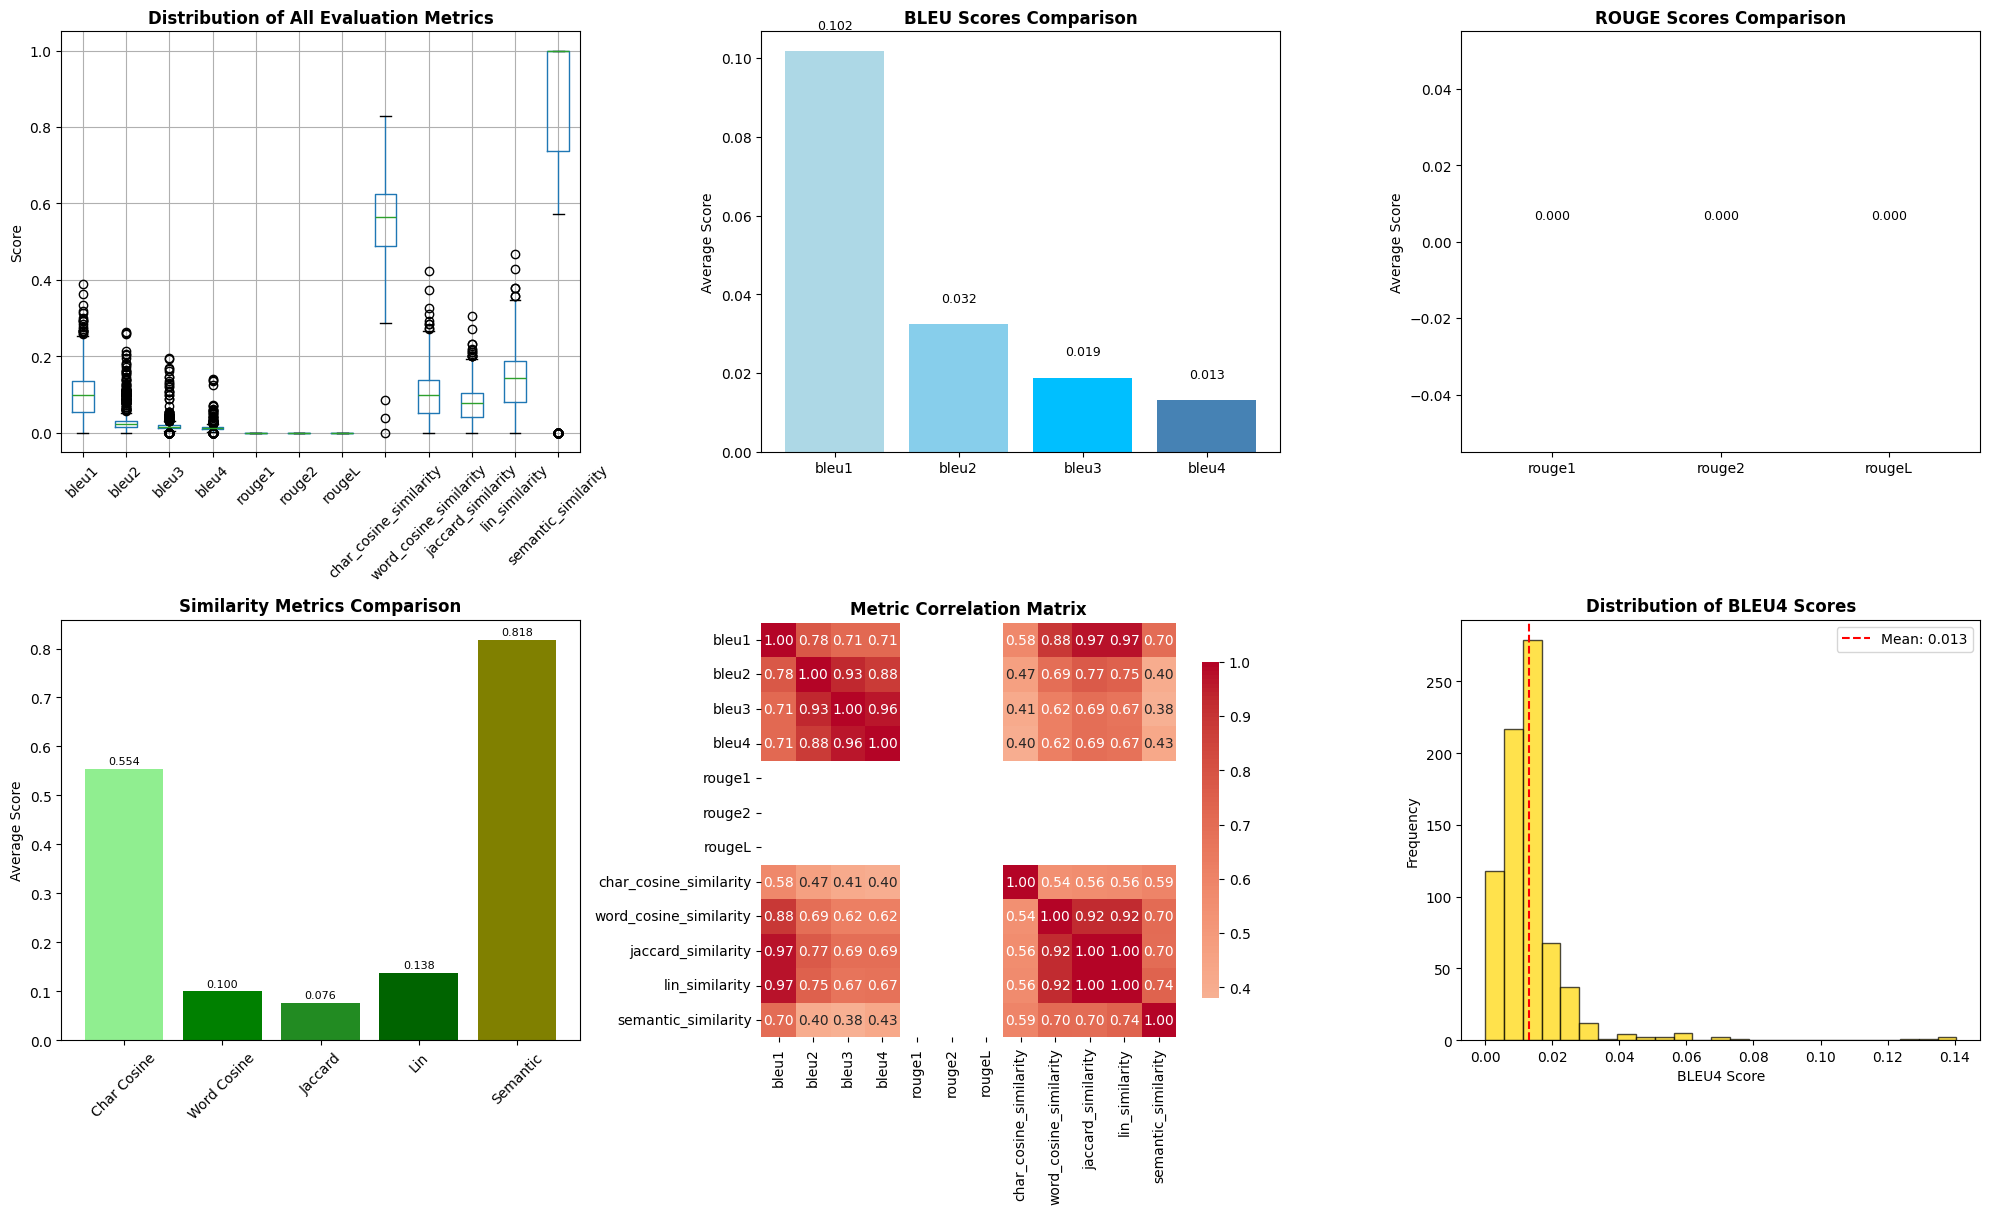

💾 Comprehensive Excel file created: comprehensive_evaluation_results.xlsx
💾 Results saved to:
  - detailed_arabic_caption_evaluation_results.csv (Original data + all metrics)
  - metrics_only_evaluation_results.csv (Metrics only)
  - enhanced_evaluation_summary.json (Summary statistics)


{'results_df':       bleu1   bleu2   bleu3   bleu4  rouge1  rouge2  rougeL  \
 0    0.1667  0.0313  0.0190  0.0142     0.0     0.0       0   
 1    0.1177  0.0601  0.0395  0.0176     0.0     0.0       0   
 2    0.1538  0.0358  0.0235  0.0185     0.0     0.0       0   
 3    0.1579  0.0296  0.0180  0.0134     0.0     0.0       0   
 4    0.0476  0.0154  0.0113  0.0091     0.0     0.0       0   
 ..      ...     ...     ...     ...     ...     ...     ...   
 747  0.1429  0.0267  0.0162  0.0120     0.0     0.0       0   
 748  0.1429  0.0331  0.0217  0.0170     0.0     0.0       0   
 749  0.0833  0.0190  0.0123  0.0094     0.0     0.0       0   
 750  0.0909  0.0208  0.0135  0.0103     0.0     0.0       0   
 751  0.2000  0.1026  0.0401  0.0242     0.0     0.0       0   
 
      char_cosine_similarity  word_cosine_similarity  jaccard_similarity  \
 0                    0.4904                  0.1363              0.1250   
 1                    0.8185                  0.1711            

In [8]:
df=pd.read_csv('/content/drive/MyDrive/ImageVal/Test/Arabic_captions_nofinetune_2nd_round.csv')
evaluate_arabic_captions(df)

DataFrame columns: ['Unnamed: 0', 'File Name', 'Description', 'Keywords', 'arabic_caption']
DataFrame shape: (752, 5)

First few rows:
                                         Description  \
0  صورة لجنود من جيش الجهاد المقدس في أعقاب حرب 1948   
1  صورة من مجلة بريطانية لبدو فلسطين في مناسبة اج...   
2  صورة لمظاهرة في البلدة القديمة بالقدس، يرجح أن...   
3  صورة لجنود من جيش الجهاد المقدس في أعقاب حرب 1948   
4  صورة لفاطمة  خليل غزال وسط الثوار الفلسطينيين ...   

                                      arabic_caption  
0  صورة لجيش فلسطيني يحمل السلاح في مواجهة الاحتل...  
1  البدو يحملون البنادق والسيوف، يتجهون إلى مكاتب...  
2             الاستقبال الرسمي لرئيس الدولة في القدس  
3  صورة لجيش الثوار في فلسطين، يحملون الأسلحة ويس...  
4    صورة تاريخية لجيش فلسطيني يحمي أرضه وشعبه منين.  

Missing values in Description: 0
Missing values in arabic_caption: 0

Cleaned dataset shape: (752, 5)
🚀 Starting Arabic Caption Evaluation...
Dataset size: 752 samples
Reference column: Description

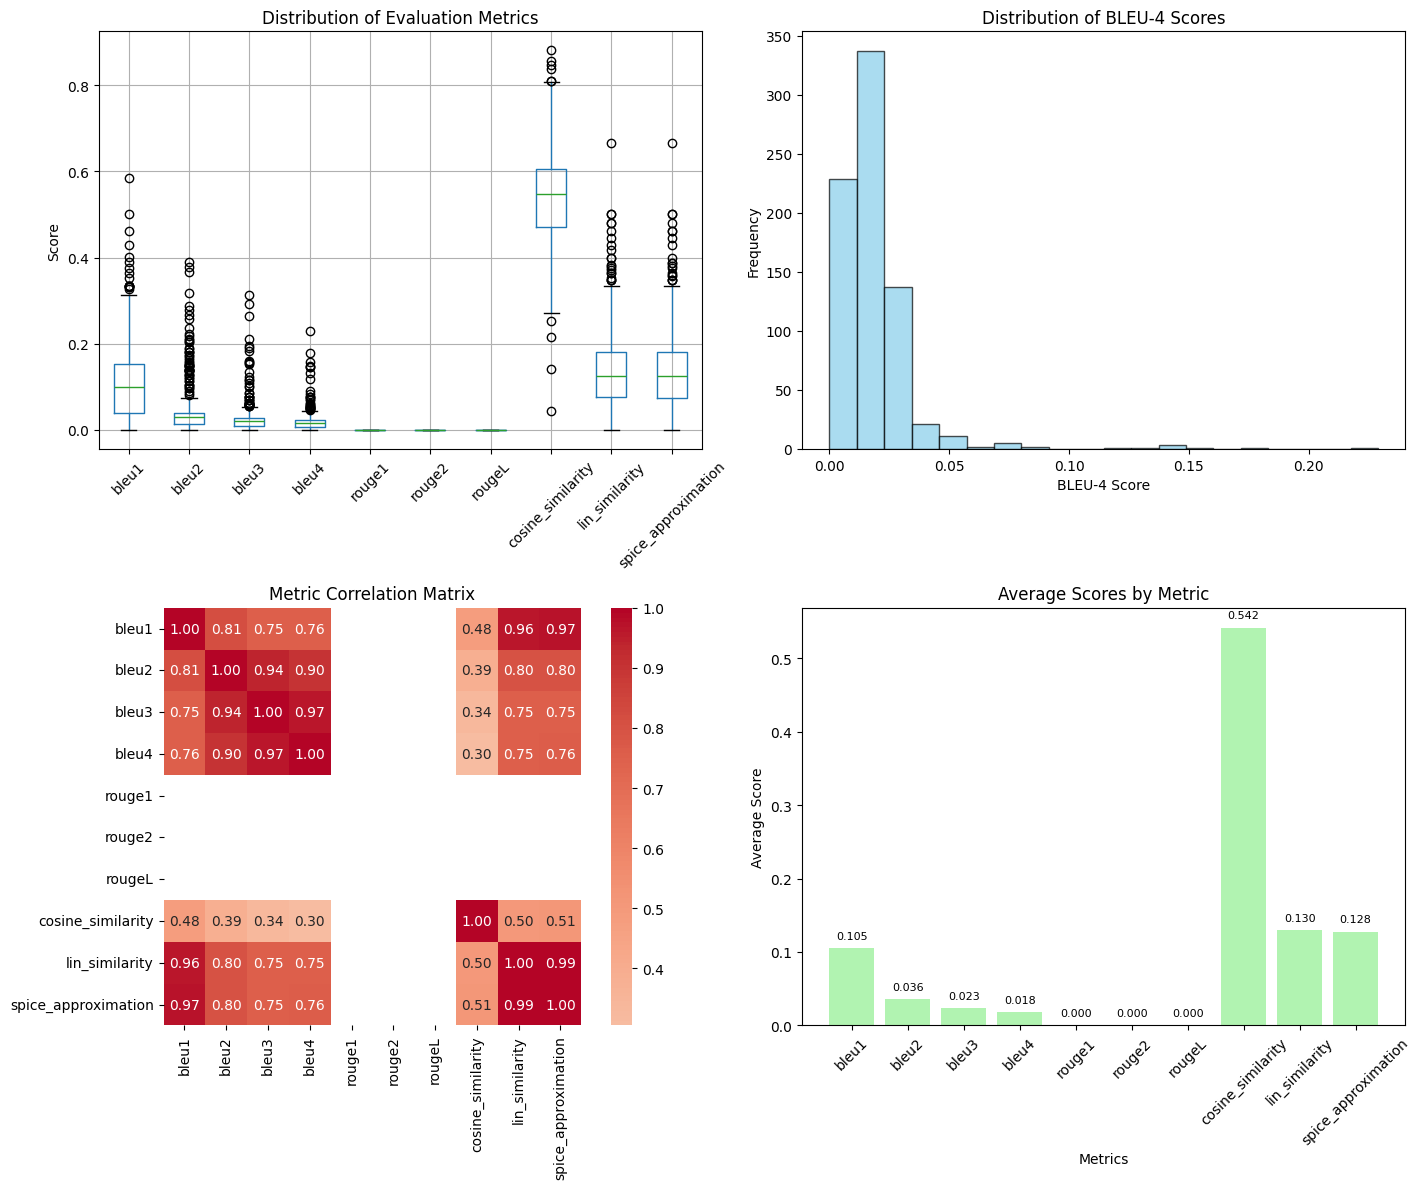

💾 Results saved to:
  - arabic_caption_evaluation_results.csv
  - evaluation_summary.json

🏆 TOP 10 BEST CAPTIONS (by BLEU-4):

Rank 1 (BLEU-4: 0.2289):
Ground Truth: صورة لحاييم وايزمان أثناء إلقائه خطابًا في مؤتمر بيلتمور في نيويورك عام 1942.
Generated:    اجتماع مؤتمر بيلتمور في نيويورك عام 1942، يتحدث فيه شيمون ويزمان عن حق العودة إلى فللسطين.

Rank 2 (BLEU-4: 0.1782):
Ground Truth: صورة لأحد منازل المستوطنين في تل أبيب
Generated:    منزل مهدم في تل أبيب

Rank 3 (BLEU-4: 0.1584):
Ground Truth: صورة للمشاركين في مؤتمر محبي صهيون في بولندا عام 1884
Generated:    صورة للمشاركين في مؤتمر هوفيف زيون عام 1884، دليل على التوجه نحو تجسيد الحلم اليهودي في فللسطين.

Rank 4 (BLEU-4: 0.1477):
Ground Truth: صورة لمستوطن متسول في أحد شوارع تل أبيب
Generated:    الجوع يهلكنا، فلداً يتسول في شوارع تل أبيب.

Rank 5 (BLEU-4: 0.1464):
Ground Truth: صورة لدخول الجيش البريطاني القدس - 1917
Generated:    الجيش البريطاني يدخل القدس 1917

Rank 6 (BLEU-4: 0.1459):
Ground Truth: صورة من مجلة لعرض عسكري لمجن

In [ ]:
# Installation requirements
"""
pip install rouge-score
pip install nltk
pip install scikit-learn
pip install matplotlib seaborn
"""

import pandas as pd

# Load your data (replace with your actual file path)
# Option 1: If you have a CSV file
df = pd.read_csv('/content/sample_data/captions_No_finetune_Qwen.csv')

# Option 2: If you have a JSON file
# import json
# with open('/content/drive/MyDrive/ImageVal/generated_arabic_captions_lora.json', 'r', encoding='utf-8') as f:
#     data = json.load(f)
# df = pd.DataFrame(data)

# Verify your data structure
print("DataFrame columns:", df.columns.tolist())
print("DataFrame shape:", df.shape)
print("\nFirst few rows:")
print(df[['Description', 'arabic_caption']].head())

# Check for missing values
print(f"\nMissing values in Description: {df['Description'].isna().sum()}")
print(f"Missing values in arabic_caption: {df['arabic_caption'].isna().sum()}")

# Remove rows with missing values if any
df_clean = df.dropna(subset=['Description', 'arabic_caption'])
print(f"\nCleaned dataset shape: {df_clean.shape}")

# Run the evaluation
evaluation_results = evaluate_arabic_captions(
    df_clean,
    ref_col='Description',  # Ground truth column
    cand_col='arabic_caption',  # Generated caption column
    save_results=True
)

# Access individual results
results_df = evaluation_results['results_df']
summary = evaluation_results['summary']

# Print top 10 best and worst performing captions
print("\n🏆 TOP 10 BEST CAPTIONS (by BLEU-4):")
print("=" * 60)
best_captions = results_df.nlargest(10, 'bleu4')
for rank, (_, row) in enumerate(best_captions.iterrows(), 1):
    original_idx = int(row['original_index'])
    print(f"\nRank {rank} (BLEU-4: {row['bleu4']:.4f}):")
    print(f"Ground Truth: {df_clean.iloc[original_idx]['Description']}")
    print(f"Generated:    {df_clean.iloc[original_idx]['arabic_caption']}")

print("\n💔 TOP 10 WORST CAPTIONS (by BLEU-4):")
print("=" * 60)
worst_captions = results_df.nsmallest(10, 'bleu4')
for rank, (_, row) in enumerate(worst_captions.iterrows(), 1):
    original_idx = int(row['original_index'])
    print(f"\nRank {rank} (BLEU-4: {row['bleu4']:.4f}):")
    print(f"Ground Truth: {df_clean.iloc[original_idx]['Description']}")
    print(f"Generated:    {df_clean.iloc[original_idx]['arabic_caption']}")

# Additional analysis
print("\n📊 DETAILED STATISTICS:")
print("=" * 50)

# Score distribution
metrics = ['bleu4', 'rouge1', 'rougeL', 'cosine_similarity']
for metric in metrics:
    print(f"\n{metric.upper()}:")
    print(f"  Mean: {results_df[metric].mean():.4f}")
    print(f"  Std:  {results_df[metric].std():.4f}")
    print(f"  Min:  {results_df[metric].min():.4f}")
    print(f"  Max:  {results_df[metric].max():.4f}")
    print(f"  25%:  {results_df[metric].quantile(0.25):.4f}")
    print(f"  50%:  {results_df[metric].quantile(0.50):.4f}")
    print(f"  75%:  {results_df[metric].quantile(0.75):.4f}")

# Performance categories
print(f"\n🎯 PERFORMANCE CATEGORIES (BLEU-4):")
print(f"Excellent (>0.5): {len(results_df[results_df['bleu4'] > 0.5])} captions")
print(f"Good (0.3-0.5):   {len(results_df[(results_df['bleu4'] > 0.3) & (results_df['bleu4'] <= 0.5)])} captions")
print(f"Fair (0.1-0.3):   {len(results_df[(results_df['bleu4'] > 0.1) & (results_df['bleu4'] <= 0.3)])} captions")
print(f"Poor (≤0.1):      {len(results_df[results_df['bleu4'] <= 0.1])} captions")

# Correlation analysis
print(f"\n🔗 METRIC CORRELATIONS:")
correlation_matrix = results_df[['bleu4', 'rouge1', 'rougeL', 'cosine_similarity', 'lin_similarity']].corr()
print(correlation_matrix)

# Save enhanced results with original text
# Reset index for both dataframes to ensure proper alignment
df_clean_reset = df_clean.reset_index(drop=True)
enhanced_df = pd.concat([
    df_clean_reset,
    results_df.drop('original_index', axis=1)
], axis=1)

enhanced_df.to_csv('detailed_evaluation_results.csv', index=False)
print(f"\n💾 Enhanced results saved to 'detailed_evaluation_results.csv'")